In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import islice
import numpy as np
from ipywidgets import widgets

残差块里首先有2个有相同输出通道数的$3\times 3$卷积层.
每个卷积层后接一个批量规范化层和ReLU激活函数.
然后我们通过跨层数据通路，跳过这2个卷积运算，将输入直接加在最后的ReLU激活函数前.
这样的设计要求2个卷积层的输出与输入形状一样，从而使它们可以相加.
如果想改变通道数，就需要引入一个额外的$1\times 1$卷积层来将输入变换成需要的形状后再做相加运算.
残差块的实现如下：<br>
Source: https://zh-v2.d2l.ai/chapter_convolutional-modern/resnet.html

In [15]:
# Source: https://zh-v2.d2l.ai/chapter_convolutional-modern/resnet.html
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

ResNet使用4个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块.
第一个模块的通道数同输入通道数一致.
由于之前已经使用了步幅为2的最大汇聚层，所以无须减小高和宽.
之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半.

In [16]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

ResNet的前两层：
在输出通道数为64、步幅为2的$7 \times 7$卷积层后，接步幅为2的$3 \times 3$的最大汇聚层.
不同之处在于ResNet每个卷积层后增加了批量规范化层.
接着在ResNet加入所有残差块，这里每个模块使用2个残差块.
最后，在ResNet中加入全局平均汇聚层，以及全连接层输出.


In [17]:

b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), nn.Linear(512, 10))

#### 加载数据集

In [18]:
# 加载MNIST数据集
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 将图像调整到224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # 归一化
])

train_dataset = datasets.MNIST(root='/home/panix/Documents/Pycharm/DeepLearning/data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='/home/panix/Documents/Pycharm/DeepLearning/data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

#### 测试数据集

In [19]:
print(f'train_dataset = {train_dataset}')
print(f'train_dataset.classes = {train_dataset.classes}')
print(f'train_dataset.train_data.shape = {train_dataset.train_data.shape}')
print(f'train_dataset.train_labels[0:48] = {train_dataset.train_labels[0:48]}')
# print(train_dataset.download)
# print(train_dataset[1])
# print(train_dataset.data[0])
print('train_dataset[0] = ', type(train_dataset[0]), train_dataset[0])
print('train_dataset[0][0] = ', type(train_dataset[0][0]), train_dataset[0][0].shape, train_dataset[0][0])
data = train_dataset[0][0].numpy()
def show_matrix():
    numpy_data = train_dataset.data[0].numpy()
    formatted_rows = ['\t'.join(map(str, row)) for row in numpy_data]
    for row in formatted_rows:
        print(row)
show_matrix()
print(train_dataset.targets[0])

train_dataset = Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/panix/Documents/Pycharm/DeepLearning/data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )
train_dataset.classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
train_dataset.train_data.shape = torch.Size([60000, 28, 28])
train_dataset.train_labels[0:48] = tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5])
train_dataset[0] =  <class 'tuple'> (tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -

#### 读取并展示数据中的图片和标签

Image shape: torch.Size([1, 224, 224])


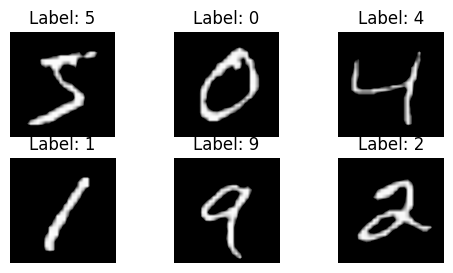

In [24]:
images, labels = zip(*[train_dataset[i] for i in range(6)])
print("Image shape:", images[0].shape)
# print(images[0]) # [[[-1,...,-1]...[-1,...,-1]]]

# 创建一个包含6个子图的网格
fig = plt.figure(figsize=(6, 3))
for i in range(6):
    # 在2x3的网格中添加子图
    ax = fig.add_subplot(2, 3, i + 1)
    # 关闭坐标轴
    ax.axis('off')
    # 去掉多余的维度,将把(1, 224, 224)的张量转换为(224, 224)显示图像
    # imshow 函数用于在子图上显示图像.cmap='gray' 表示使用灰度颜色映
    # vmin=0 和 vmax=1 设置灰度图像的最小和最大值，以确保正确的显示范围.
    ax.imshow(images[i].squeeze(), cmap='gray', vmin=0, vmax=1)
    # 在图像上方显示标签
    ax.set_title(f"Label: {labels[i]}")
plt.show()

#### 测试加载器并展示图片

torch.Size([1, 224, 224]) tensor(9)


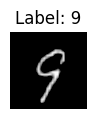

In [26]:
# 从 DataLoader 中获取一个 batch 的数据,获取到的数据是随机的
for batch_idx, (images, labels) in enumerate(train_loader):
    # 选择第一个样本
    image = images[0]
    label = labels[0]
    break
print(image.shape, label)
# 将图像从 Tensor 转换为 NumPy 数组
image_np = image.numpy()

# 调整维度顺序以适应 matplotlib
image_np = image_np.transpose((1, 2, 0))

# 使用 matplotlib 显示图像
plt.figure(figsize=(1, 1))
plt.imshow(image_np.squeeze(), cmap='gray', vmin=0, vmax=1)
plt.title(f"Label: {label.item()}")
plt.axis('off')  # 关闭坐标轴
plt.show()

#### tqdm进度条和数据测试

In [30]:
progress_bar = tqdm(train_loader, desc="Training", unit="batch")  # 添加进度条
for X, y in progress_bar:
    print(X.shape, y.shape)
    break

# 迭代数据获取方法,注意每个获取的是一个barch(即128个)的数据点,不是一个数据点
# 创建一个迭代器
iterator = iter(progress_bar)
X, y= next(iterator) # next
print("Batch shapes:", X.shape, y.shape)
print(X[0].shape)

# itertools.islice()
from itertools import islice
first_batch = list(islice(progress_bar, 2))
X, y = first_batch[1]
print("First batch shapes:", X.shape, y.shape)


# print(type(X), type(y), type(progress_bar), type(train_loader))
# print(test_loader.dataset.__class__,test_loader.batch_sampler)
# print(test_loader.dataset.data.shape, test_loader.dataset.targets.shape)


Training:   0%|          | 0/469 [00:00<?, ?batch/s]

torch.Size([128, 1, 224, 224]) torch.Size([128])
Batch shapes: torch.Size([128, 1, 224, 224]) torch.Size([128])
torch.Size([1, 224, 224])
First batch shapes: torch.Size([128, 1, 224, 224]) torch.Size([128])


#### matplotlib 的动画功能测试
jupyter notebook似乎不太能展示动态图

In [29]:
# import numpy as np
# import matplotlib.pyplot as plt
# fig = plt.figure()
# ax = fig.subplots()

# t=np.linspace(0,10,100)
# y=np.sin(t)
# ax.axis([0,10,0,2])
# ax.set_aspect(3)

# while True:
#     ax.plot(t,y)
#     plt.pause(0.1)  #显示图形并暂停。注意用time.sleep不起作用
#     ax.cla()        #清除图形
#     t+=np.pi/30     #更新数据
#     y=np.sin(t)


#### 训练函数定义

In [31]:
def train(net, train_loader, loss, optimizer, device):
    net.train()
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    # batch_count = 0  # 用于记录已经处理了多少个批次
    # fig, ax = plt.subplots(figsize=(5, 5)) # 
    # fig.show()
    # tqdm接收迭代对象;描述文本:Training;
    progress_bar = tqdm(train_loader, desc="Training", unit="batch")  # 添加进度条
    for X, y in progress_bar:
        X, y = X.to(device), y.to(device)
        # 每处理100个批次展示一次数据
        # if batch_count % 10 == 0:
        #     # 从当前批次中选取一张图片展示
        #     show_image(X[0].cpu(), y[0].cpu(), ax)
        #     plt.pause(0.001)  # 确保图像更新
        y_hat = net(X) # 前向传播，得到预测值
        l = loss(y_hat, y) # 预测值 y_hat 与真实标签 y 之间的损失
        optimizer.zero_grad() # 清除优化器中累积的梯度
        l.backward() # 反向传播，计算梯度
        optimizer.step() # 更新模型参数
        train_l_sum += l.cpu().item() # 累计整个训练周期的损失总和
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item() # 累计整个训练周期的准确率总和
        n += y.shape[0] # 已经处理的样本总数
        # batch_count += 1  # 更新批次计数
        # 动态更新进度条的信息
        progress_bar.set_postfix(loss=train_l_sum / n, accuracy=train_acc_sum / n) # 显示损失和准确率
    return train_l_sum / n, train_acc_sum / n

# Unused
def show_image(image, label, ax):
    # plt.axis('off')
    # plt.figure(figsize=(4, 4))
    # plt.imshow(image.squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    # plt.title(f"Label: {label.item()}")
    # plt.show()
    ax.clear()
    ax.axis('off')
    ax.imshow(image.squeeze(), cmap='gray', vmin=0, vmax=1)
    ax.set_title(f"Label: {label.item()}")

# Unused
def train_show(net, train_loader, loss, optimizer, device):
    net.train()
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    batch_count = 0  # 用于记录已经处理了多少个批次
    fig, ax = plt.subplots(figsize=(5, 5)) # 
    fig.show()
    # tqdm接收迭代对象;描述文本:Training;
    progress_bar = tqdm(train_loader, desc="Training", unit="batch")  # 添加进度条
    for X, y in progress_bar:
        X, y = X.to(device), y.to(device)
        # 每处理100个批次展示一次数据
        if batch_count % 10 == 0:
            # 从当前批次中选取一张图片展示
            show_image(X[0].cpu(), y[0].cpu(), ax)
            plt.pause(0.001)  # 确保图像更新
        y_hat = net(X) # 前向传播，得到预测值
        l = loss(y_hat, y) # 预测值 y_hat 与真实标签 y 之间的损失
        optimizer.zero_grad() # 清除优化器中累积的梯度
        l.backward() # 反向传播，计算梯度
        optimizer.step() # 更新模型参数
        train_l_sum += l.cpu().item() # 累计整个训练周期的损失总和
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item() # 累计整个训练周期的准确率总和
        n += y.shape[0] # 已经处理的样本总数
        # batch_count += 1  # 更新批次计数
        # 动态更新进度条的信息
        progress_bar.set_postfix(loss=train_l_sum / n, accuracy=train_acc_sum / n) # 显示损失和准确率
    return train_l_sum / n, train_acc_sum / n



#### 测试函数定义

In [35]:
def test(net, test_loader, device):
    net.eval() # 评估模式
    test_acc_sum, n = 0.0, 0 # 准确率总和,已经处理的样本总数
    with torch.no_grad(): # 禁用梯度计算，节省内存
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            y_hat = net(X) # 前向传播，得到预测值
            # 找到预测值中每行的最大值索引（即预测类别），并与真实标签 y 进行比较
            test_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0] # 已处理样本
    return test_acc_sum / n

# def test_show_error(net, test_loader, device):
#     net.eval() # 评估模式
#     test_acc_sum, n = 0.0, 0 # 准确率总和,已经处理的样本总数
#     errors = []
#     with torch.no_grad(): # 禁用梯度计算，节省内存
#         for X, y in test_loader:
#             X, y = X.to(device), y.to(device)
#             y_hat = net(X) # 前向传播，得到预测值
#             # 找到预测值中每行的最大值索引（即预测类别）
#             pred_labels = y_hat.argmax(dim=1)
#             # 与真实标签 y 进行比较,累积准确率
#             # (pred_labels == y).sum():得到一个布尔数组,对该数组求和,计算出预测正确的样本数量
#             test_acc_sum += (pred_labels == y).sum().cpu().item()
#             n += y.shape[0] # 已处理样本
#             # 找到预测错误的样本的索引
#             error_index = (pred_labels != y)
#             if error_index.any():
#                 errors.extend(zip(X[error_index].cpu(), pred_labels[error_index].cpu(), y[error_index].cpu()))
#     accuracy = test_acc_sum / n
#     return accuracy

##### 单批次测试数据并展示函数定义

In [37]:
# test_show_error测试
def test_show_error_demo(net, test_loader, device):
    net.eval() # 评估模式
    test_acc_sum, n = 0.0, 0 # 准确率总和,已经处理的样本总数
    errors = []
    with torch.no_grad(): # 禁用梯度计算，节省内存
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            y_hat = net(X) # 前向传播，得到预测值
            # 找到预测值中每行的最大值索引（即预测类别）
            pred_labels = y_hat.argmax(dim=1)
            # print(pred_labels)
            bool_tensor = (pred_labels != y) # 与真实标签 y 进行比较,得到一个布尔数组
            # print(type(bool_tensor))
            # 对该数组求和,计算出预测正确的样本数量
            test_acc_sum += bool_tensor.sum().cpu().item()
            n += y.shape[0] # 已处理样本

            # .nonzero() 方法用于找到张量中非零元素的位置
            error_index = bool_tensor.nonzero(as_tuple=True)[0] # 获得所有预测错误样本的索引
            print(error_index)
            if len(error_index) > 0:
                errors.extend(zip(X[error_index].cpu(), pred_labels[error_index].cpu(), y[error_index].cpu()))

            break # 仅测试一批数据

    accuracy = test_acc_sum / n
    display_errors(errors)
    return accuracy

def display_errors(errors):
    fig, axs = plt.subplots(nrows=len(errors), ncols=3, figsize=(10, 3 * len(errors)))
    for i, (img, pred, true) in enumerate(errors[:len(errors)]):
        img = img.permute(1, 2, 0).numpy()
        axs[i, 0].imshow(img, cmap='gray', vmin=0, vmax=1)
        axs[i, 0].axis('off')
        axs[i, 0].set_title('Image')
        
        axs[i, 1].text(0.5, 0.5, f'Predicted: {pred.item()}', ha='center', va='center', fontsize=12)
        axs[i, 1].axis('off')
        axs[i, 1].set_title('Prediction')
        
        axs[i, 2].text(0.5, 0.5, f'True: {true.item()}', ha='center', va='center', fontsize=12)
        axs[i, 2].axis('off')
        axs[i, 2].set_title('True Label')
    
    plt.tight_layout()
    plt.show()


# acc = test_show_error_demo(net, test_loader, device)

##### 多批次数据测试并展示

In [38]:
# TODO

### 单轮训练及测试

#### 训练参数定义

In [42]:
lr, num_epochs = 0.01, 1 # 学习率,训练周期数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 将模型移动到设备上
net = net.to(device)

optimizer = optim.Adam(net.parameters(), lr=lr) # 梯度下降优化方法
loss = nn.CrossEntropyLoss() # 交叉熵损失函数

#### 单轮训练

In [43]:
train_loss, train_acc = train(net, train_loader, loss, optimizer, device)

Training: 100%|██████████| 469/469 [02:15<00:00,  3.45batch/s, accuracy=0.869, loss=0.00326]


#### 单轮测试

In [47]:
test_acc = test(net, test_loader, device)
# 将当前epoch的损失和准确率添加到列表中
train_losses.append(train_loss)
train_accuracies.append(train_acc)
test_accuracies.append(test_acc)
print(f'loss {train_loss:.4f}, train acc {train_acc:.4f}, test acc {test_acc:.4f}')


loss 0.0033, train acc 0.8686, test acc 0.9196


#### 单批次测试并展示预测错误的数据

tensor([18, 22, 92, 94, 97], device='cuda:0')


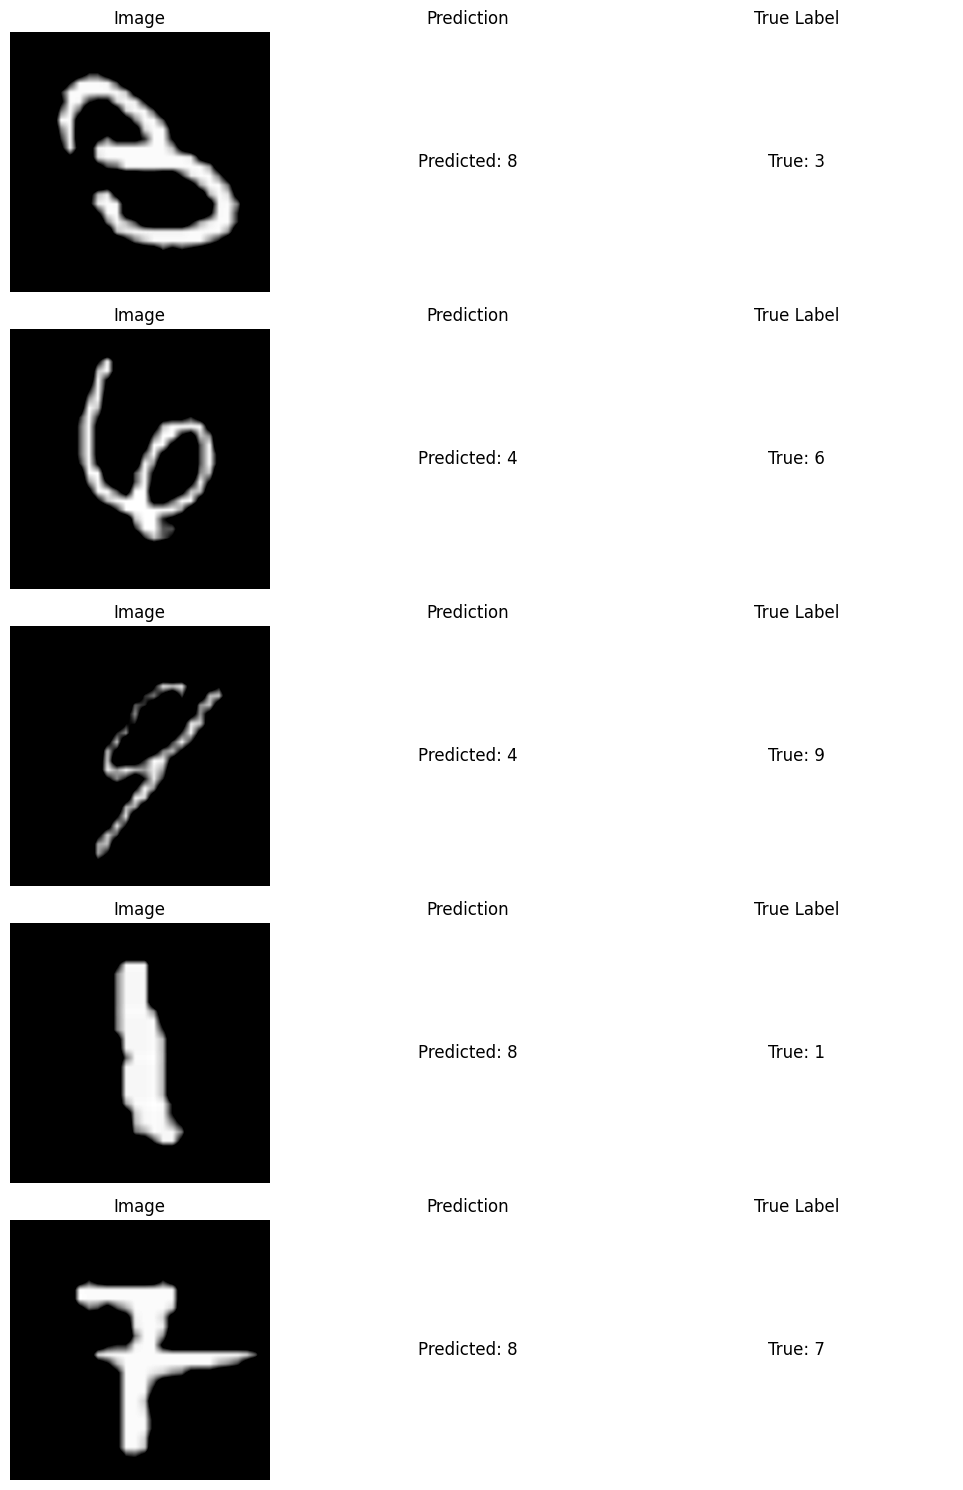

In [48]:
acc = test_show_error_demo(net, test_loader, device)

#### 测试并展示预测错误的数据

In [36]:
# TODO
# test_acc = test_show_error(net, test_loader, device)
# print(f'epoch {1}, loss {train_loss:.4f}, train acc {train_acc:.4f}, test acc {test_acc:.4f}')

### 多轮训练和测试

#### 训练参数定义

In [49]:
lr, num_epochs = 0.01, 3 # 学习率,训练周期数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 将模型移动到设备上
net = net.to(device)

optimizer = optim.Adam(net.parameters(), lr=lr) # 梯度下降优化方法
loss = nn.CrossEntropyLoss() # 交叉熵损失函数

#### 多轮训练和测试模型

In [53]:
# 初始化列表来记录每一轮的损失和准确率
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(net, train_loader, loss, optimizer, device)
    test_acc = test(net, test_loader, device)
    # 将当前epoch的损失和准确率添加到列表中
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f'epoch {epoch + 1}, loss {train_loss:.4f}, train acc {train_acc:.4f}, test acc {test_acc:.4f}')

Training: 100%|██████████| 469/469 [02:18<00:00,  3.38batch/s, accuracy=0.991, loss=0.000224]


epoch 1, loss 0.0002, train acc 0.9912, test acc 0.9908


Training: 100%|██████████| 469/469 [02:21<00:00,  3.32batch/s, accuracy=0.992, loss=0.000201]


epoch 2, loss 0.0002, train acc 0.9921, test acc 0.9884


Training: 100%|██████████| 469/469 [02:22<00:00,  3.30batch/s, accuracy=0.993, loss=0.000172]


epoch 3, loss 0.0002, train acc 0.9932, test acc 0.9809


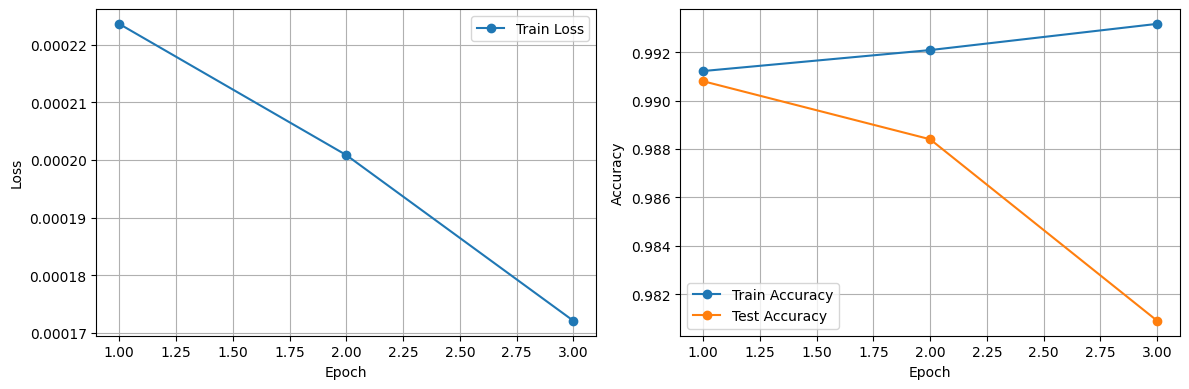

In [54]:
def show_plot():
    # 绘制训练损失和准确率
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker = 'o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', marker = 'o')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', marker = 'o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.tight_layout()

    plt.show()

show_plot()